In [8]:
from datasets import load_dataset
from datasets import Dataset

dataset = load_dataset("csv", data_files="data/hate_train.csv")['train']
dataset = dataset.train_test_split(test_size=0.2, seed=42)
dataset = dataset.rename_column("sentence", "text")
print(dataset)

with open("data/hate_test_data.txt", encoding="utf-8") as f:
    test_lines = [line.strip() for line in f if line.strip()]

test_dataset = Dataset.from_dict({"text": test_lines})
print(test_dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 8032
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2009
    })
})
Dataset({
    features: ['text'],
    num_rows: 1000
})


In [9]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=512)

tokenized_train_dataset = dataset["train"].map(tokenize_function, batched=True)
tokenized_val_dataset = dataset["test"].map(tokenize_function, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)

print(tokenized_train_dataset)
print(tokenized_val_dataset)
print(tokenized_test_dataset)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 8032
})
Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 2009
})
Dataset({
    features: ['text', 'input_ids', 'attention_mask'],
    num_rows: 1000
})


In [10]:
from transformers import AutoModelForSequenceClassification
import torch

model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [11]:
from transformers import TrainingArguments

training_args = TrainingArguments(output_dir="test_trainer", eval_strategy="steps", report_to="none",
                                  per_device_eval_batch_size=32, per_device_train_batch_size=32,
                                  logging_steps=100, fp16=True, num_train_epochs=2)

In [12]:
import numpy as np
from evaluate import load

metric = load("accuracy")

def compute_metrics(eval_pred):
  logits, labels = eval_pred
  predictions = np.argmax(logits, axis=-1)
  return metric.compute(predictions=predictions, references=labels)

In [13]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    compute_metrics=compute_metrics,
)

In [14]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy
100,0.300900,0.287303,0.913888
200,0.273200,0.283289,0.913888
300,0.277400,0.273600,0.913888
400,0.234200,0.273699,0.913888
500,0.230400,0.247230,0.906919


TrainOutput(global_step=502, training_loss=0.26331526112271497, metrics={'train_runtime': 231.4664, 'train_samples_per_second': 69.401, 'train_steps_per_second': 2.169, 'total_flos': 2127956292009984.0, 'train_loss': 0.26331526112271497, 'epoch': 2.0})

In [15]:
results = trainer.predict(tokenized_val_dataset)
predictions = results.predictions
true_labels = results.label_ids
predicted_labels = np.argmax(predictions, axis=-1)

Accuracy: 0.9064

              precision    recall  f1-score  support
Normal         0.922998  0.979303  0.950317   1836.0
Hate           0.377049  0.132948  0.196581    173.0
macro avg      0.650024  0.556125  0.573449   2009.0
weighted avg   0.875985  0.906421  0.885411   2009.0



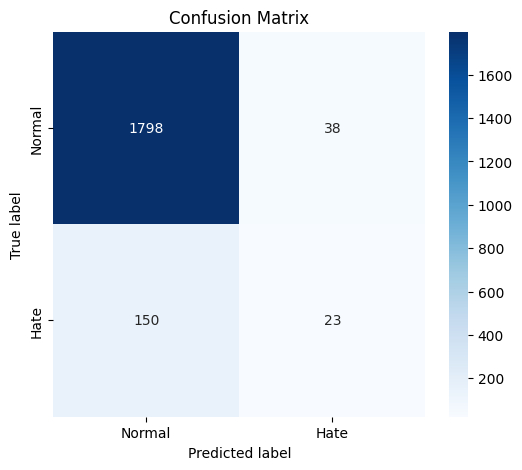

In [16]:
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

label_names = ["Normal", "Hate"]

report = classification_report(true_labels, predicted_labels, output_dict=True, target_names=label_names)
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print(f"Accuracy: {report['accuracy']:.4f}")
print()
report_df = pd.DataFrame(report).transpose()
report_df = report_df.drop(['accuracy'], errors='ignore')
print(report_df)
print()

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

In [19]:
preds = trainer.predict(tokenized_test_dataset)
predictions = np.argmax(preds.predictions, axis=-1)

In [ ]:
import pandas as pd

pd.Series(predictions).to_csv("predictions.csv", index=False, header=False)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 